# Muon tutorial

In this notebook we will perform exploratory analysis and joint dimensionality reduction on matched scRNA-seq and scATAC-seq data of healthy human brain from [10X genomics](https://www.10xgenomics.com/resources/datasets/frozen-human-healthy-brain-tissue-3-k-1-standard-2-0-0).

Here we will: 
- Learn how to handle multi-modal data objects using the python package [muon](https://muon.readthedocs.io/en/latest/index.html) 
- Try one method for joint dimensionality reduction of multi-modal data (_vertical integration_) ([Weighted Nearest Neighbors analysis](https://www.sciencedirect.com/science/article/pii/S0092867421005833))

In [ ]:
!pip3 install leidenalg

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [2]:
import muon as mu
import mudatasets
import mudata

/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset

Here we will use a dataset available for download via the python package [mudatasets](https://github.com/PMBio/mudatasets). This will download to `./data` the following files (output to [CellRanger ARC pipeline](https://support.10xgenomics.com/single-cell-multiome-atac-gex/software/pipelines/latest/output/overview)):

- Filtered feature x barcode (cell) matrix (HDF5), containing data for both RNA and ATAC
- ATAC peak annotations based on proximal genes (TSV)
- ATAC Per fragment information file (TSV.GZ)
- ATAC Per fragment information index (TSV.GZ index)

In [4]:
data_dir = './data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
mdata = mudatasets.load("brain3k_multiome", full=True, data_dir=data_dir)

■ File filtered_feature_bc_matrix.h5 from brain3k_multiome has been found at ./data/brain3k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from brain3k_multiome has been found at ./data/brain3k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from brain3k_multiome has been found at ./data/brain3k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from brain3k_multiome has been found at ./data/brain3k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from brain3k_multiome has been found at ./data/brain3k_multiome/atac_peak_annotation.tsv
■ Checksum is validated (md5) for atac_peak_annotation.tsv
■ Loading filtered_feature_bc_matrix.h5...


/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from ./data/brain3k_multiome/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/mudata/_core/mudata.py:405: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from ./data/brain3k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: ./data/brain3k_multiome/atac_fragments.tsv.gz


In [6]:
os.listdir(data_dir + 'brain3k_multiome/')

['atac_fragments.tsv.gz.tbi',
 'filtered_feature_bc_matrix.h5',
 'atac_peak_annotation.tsv',
 'atac_fragments.tsv.gz',
 'atac_peaks.bed']

The loaded data is stored in a format for annotated multimodal datasets called [MuData](https://mudata.readthedocs.io/en/latest/index.html). This allows to store data objects for both modalities in a single object similar to a python dictionary, to facilitate multi-modal analysis. First, let's look at individual objects for each data modality.  


In [37]:
rna_adata = mdata['rna'].copy()
atac_adata = mdata['atac'].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


The data for each omic view is stored in [`AnnData`](https://anndata.readthedocs.io/en/latest/index.html) ("annotated data") format. An `AnnData` object allows us to store a matrix and add annotations to its different dimensions, defined as “observations” (i.e. cells), and measured “variables” (i.e. genes for the RNA view and peaks for the ATAC view). See [this tutorial](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a quick-start on the structure of AnnData objects.

We can access the annotations on cells using `adata.obs`. Notably, since these datasets are generated with 10X Multiome, the names of all cells are matched between the two datasets (you can check using `adata.obs_names`).

In [38]:
all(atac_adata.obs_names == rna_adata.obs_names)

True

We can access the annotations on features (genes for RNA modality, peaks for ATAC modality) in `adata.var`. Here we can also store the genomic coordinates of the peaks. Notice the big imbalance in feature numbers between the two datasets.

In [39]:
rna_adata.var

,gene_ids,feature_types,genome,interval
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,chr1:29553-30267
FAM138A,ENSG00000237613,Gene Expression,GRCh38,chr1:36080-36081
OR4F5,ENSG00000186092,Gene Expression,GRCh38,chr1:65418-69055
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,chr1:120931-133723
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,chr1:91104-91105
...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,KI270728.1:1270983-1270984
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,KI270731.1:13000-13001
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,KI270734.1:72410-72411
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,KI270734.1:131493-131494


In [40]:
atac_adata.var

,gene_ids,feature_types,genome,interval
chr1:180995-181723,chr1:180995-181723,Peaks,GRCh38,chr1:180995-181723
chr1:191025-191934,chr1:191025-191934,Peaks,GRCh38,chr1:191025-191934
chr1:629469-630395,chr1:629469-630395,Peaks,GRCh38,chr1:629469-630395
chr1:633551-634475,chr1:633551-634475,Peaks,GRCh38,chr1:633551-634475
chr1:778288-779198,chr1:778288-779198,Peaks,GRCh38,chr1:778288-779198
...,...,...,...,...
KI270713.1:21467-22401,KI270713.1:21467-22401,Peaks,GRCh38,KI270713.1:21467-22401
KI270713.1:25956-26766,KI270713.1:25956-26766,Peaks,GRCh38,KI270713.1:25956-26766
KI270713.1:29714-30467,KI270713.1:29714-30467,Peaks,GRCh38,KI270713.1:29714-30467
KI270713.1:31270-32183,KI270713.1:31270-32183,Peaks,GRCh38,KI270713.1:31270-32183


## Preprocessing RNA modality

We can start preprocessing and exploring the RNA data, using the functions implemented in the python library `scanpy`. These steps roughly follow [this vignette](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). We start by computing quality control metrics for cells and genes.

In [41]:
rna_adata.var_names_make_unique()
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

The QC metrics for cells and genes have been stored in the `.obs` and `.var` slot respectively.

In [42]:
rna_adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACAGCCATAGACTT-1,498,700.0,0.0,0.000000
AAACAGCCATTATGCG-1,2862,10007.0,17.0,0.169881
AAACCAACATAGACCC-1,2315,6017.0,0.0,0.000000
AAACCGAAGATGCCTG-1,5065,15269.0,16.0,0.104787
AAACCGAAGTTAGCTA-1,2608,6996.0,9.0,0.128645
...,...,...,...,...
TTTGTGGCAAGGAATC-1,3423,8604.0,9.0,0.104603
TTTGTGGCATGCTTAG-1,2875,12456.0,3.0,0.024085
TTTGTGTTCGTTACAA-1,4266,11942.0,7.0,0.058617
TTTGTTGGTGATCAGC-1,2743,7460.0,8.0,0.107239


In [43]:
rna_adata.var

,gene_ids,feature_types,genome,interval,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,chr1:29553-30267,False,1,0.000309,99.969069,1.0
FAM138A,ENSG00000237613,Gene Expression,GRCh38,chr1:36080-36081,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,GRCh38,chr1:65418-69055,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,chr1:120931-133723,False,39,0.012063,98.793690,39.0
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,chr1:91104-91105,False,1,0.000309,99.969069,1.0
...,...,...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,KI270728.1:1270983-1270984,False,0,0.000000,100.000000,0.0
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,KI270731.1:13000-13001,False,2,0.000619,99.938138,2.0
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,KI270734.1:72410-72411,False,0,0.000000,100.000000,0.0
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,KI270734.1:131493-131494,False,97,0.033715,96.999691,109.0


/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical
/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated

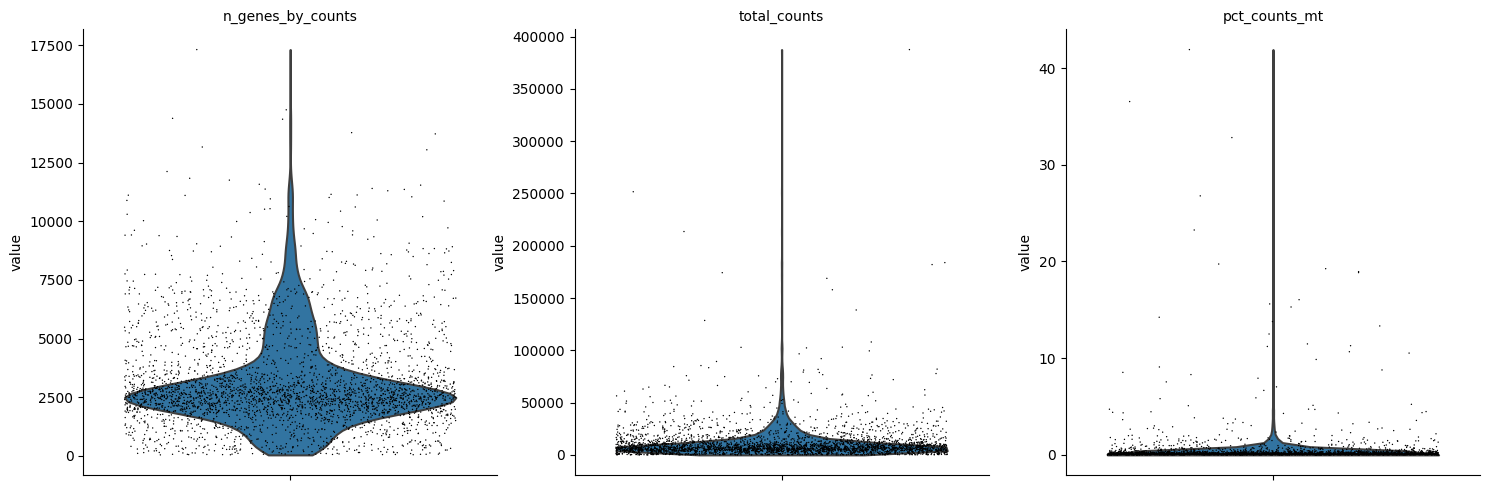

In [44]:
## Plot cell metrics
sc.pl.violin(rna_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

We use the QC metrics to filter out low quality genes and cells

In [45]:
print(f"Before: {rna_adata.n_obs} cells")
mu.pp.filter_obs(rna_adata, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 8000))
print(f"After n_genes: {rna_adata.n_obs} cells")
mu.pp.filter_obs(rna_adata, 'total_counts', lambda x: x < 40000)
print(f"After total_counts: {rna_adata.n_obs} cells")
mu.pp.filter_obs(rna_adata, 'pct_counts_mt', lambda x: x < 2)
print(f"After: {rna_adata.n_obs} cells")

Before: 3233 cells
After n_genes: 3084 cells
After total_counts: 3065 cells
After: 3020 cells


Then we normalize and log-transform the raw counts, to adjust for differences in sequencing depth between cells. __Note:__ AnnData objects allow to store multiple matrices of the same dimensions of `adata.X` (`n_obs` x `n_vars`) in a slot called `adata.layers`. Here for example we can save the raw count matrix before normalization. 

In [46]:
rna_adata.layers["counts"] = rna_adata.X.copy() ## always use .copy here!
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)
rna_adata.layers["lognorm"] = rna_adata.X.copy()

We identify highly variable genes for dimensionality reduction

In [47]:
sc.pp.highly_variable_genes(rna_adata, min_mean=0.02, max_mean=4, min_disp=0.5)

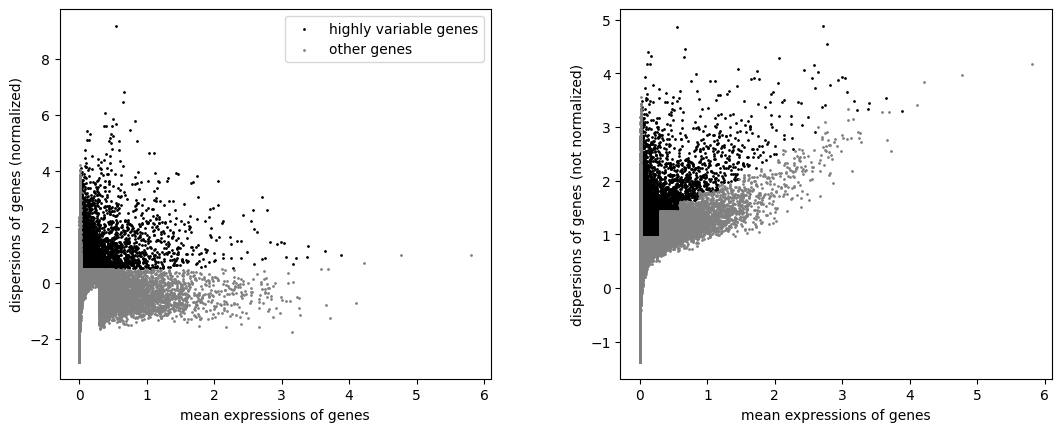

In [48]:
sc.pl.highly_variable_genes(rna_adata)

Let's check how many genes are identified as highly variable

In [49]:
sum(rna_adata.var.highly_variable)

5924

Next we run dimensionality reduction with PCA and use principal components to construct a K-nearest neighbor graph for UMAP embedding and clustering.

In [50]:
sc.pp.scale(rna_adata, max_value=10) ## scales the data (z-scoring)

In [51]:
sc.pp.pca(rna_adata, svd_solver='arpack') ## Runs principal component analysis
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=20) ## Compute k-nearest neighbor graph based on PCs 
sc.tl.umap(rna_adata, spread=1., min_dist=.5, random_state=11) ## Compute UMAP

In [52]:
sc.tl.leiden(rna_adata, resolution=0.5) ## Compute graph-based clustering with Leiden algorithm

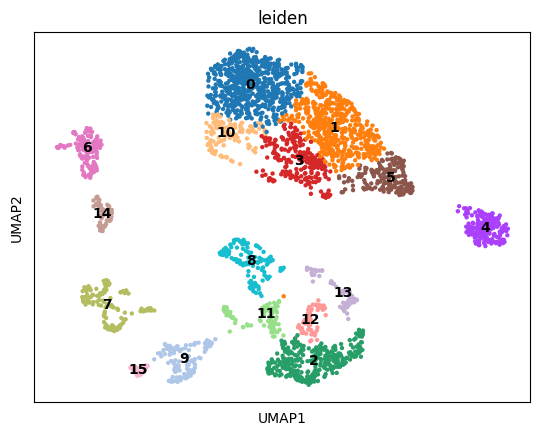

In [53]:
sc.pl.umap(rna_adata, color=["leiden"], legend_loc="on data")

We now need to give a biologically meaningful label each cluster identified, and the simplest way to do this is by looking at marker genes. Here is a panel for the main cell types in the human brain cortex.

In [54]:
marker_genes = {'oligodendrocytes':["PLP1", "CNP", "CTNNA3"],
                'astrocytes':["SLC1A2"], 'microglia':["SRGN"], 
                'OPCs':["VCAN"], ## Oligodendrocyte precursor cell
                'excitatory neurons':["SLC17A7", "LAMP5", "CBLN2", "RORB", "FOXP2"],
                'inbibitory neurons':["GAD1", "GAD2", "LHX6", "ADARB2"]}

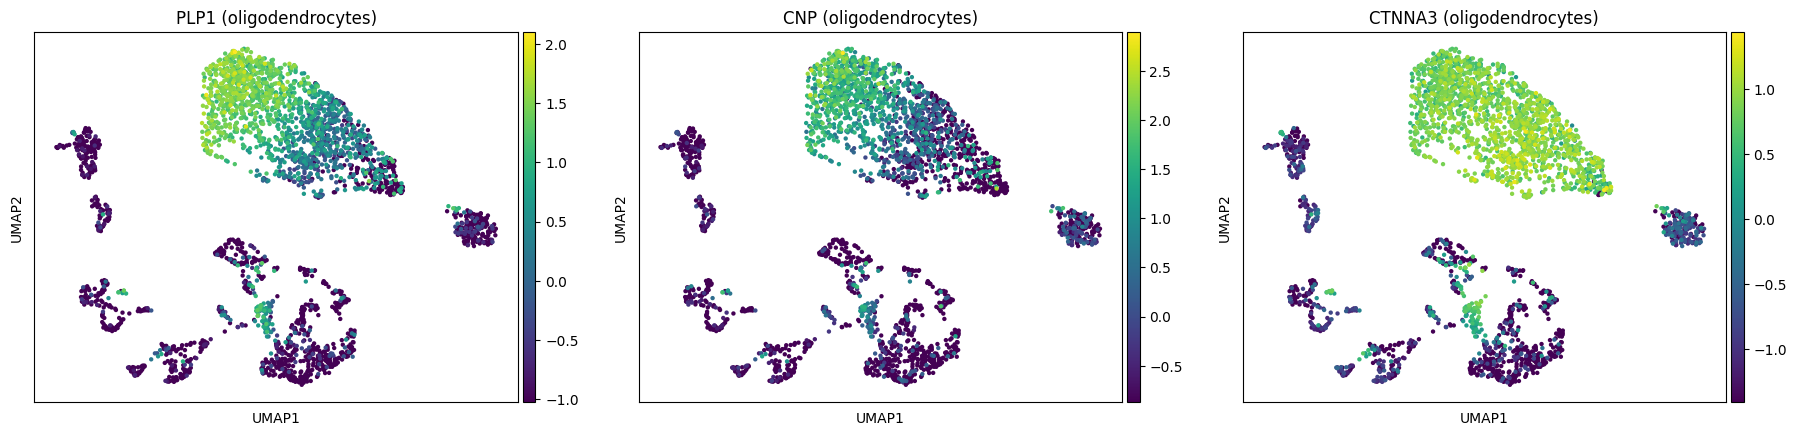

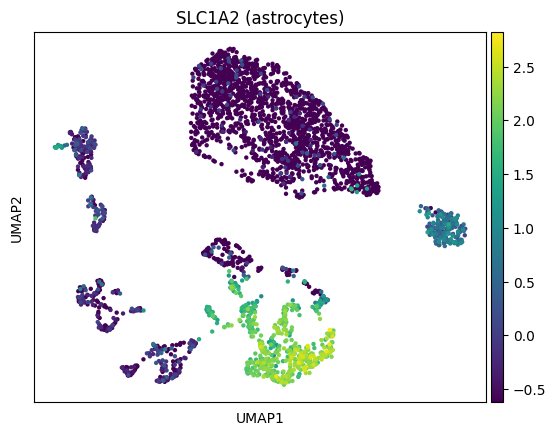

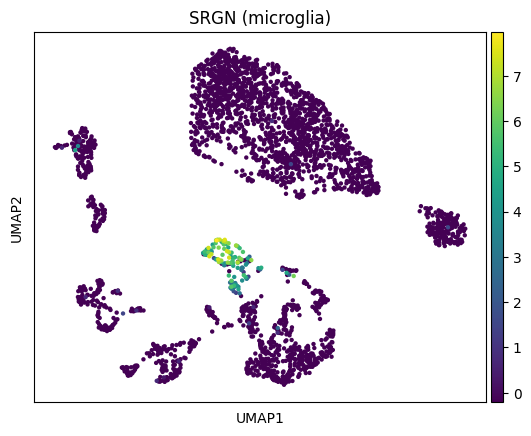

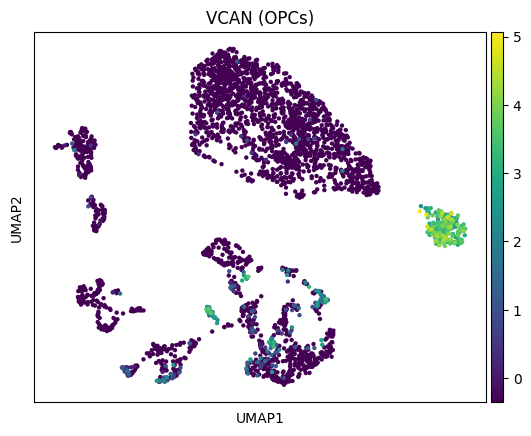

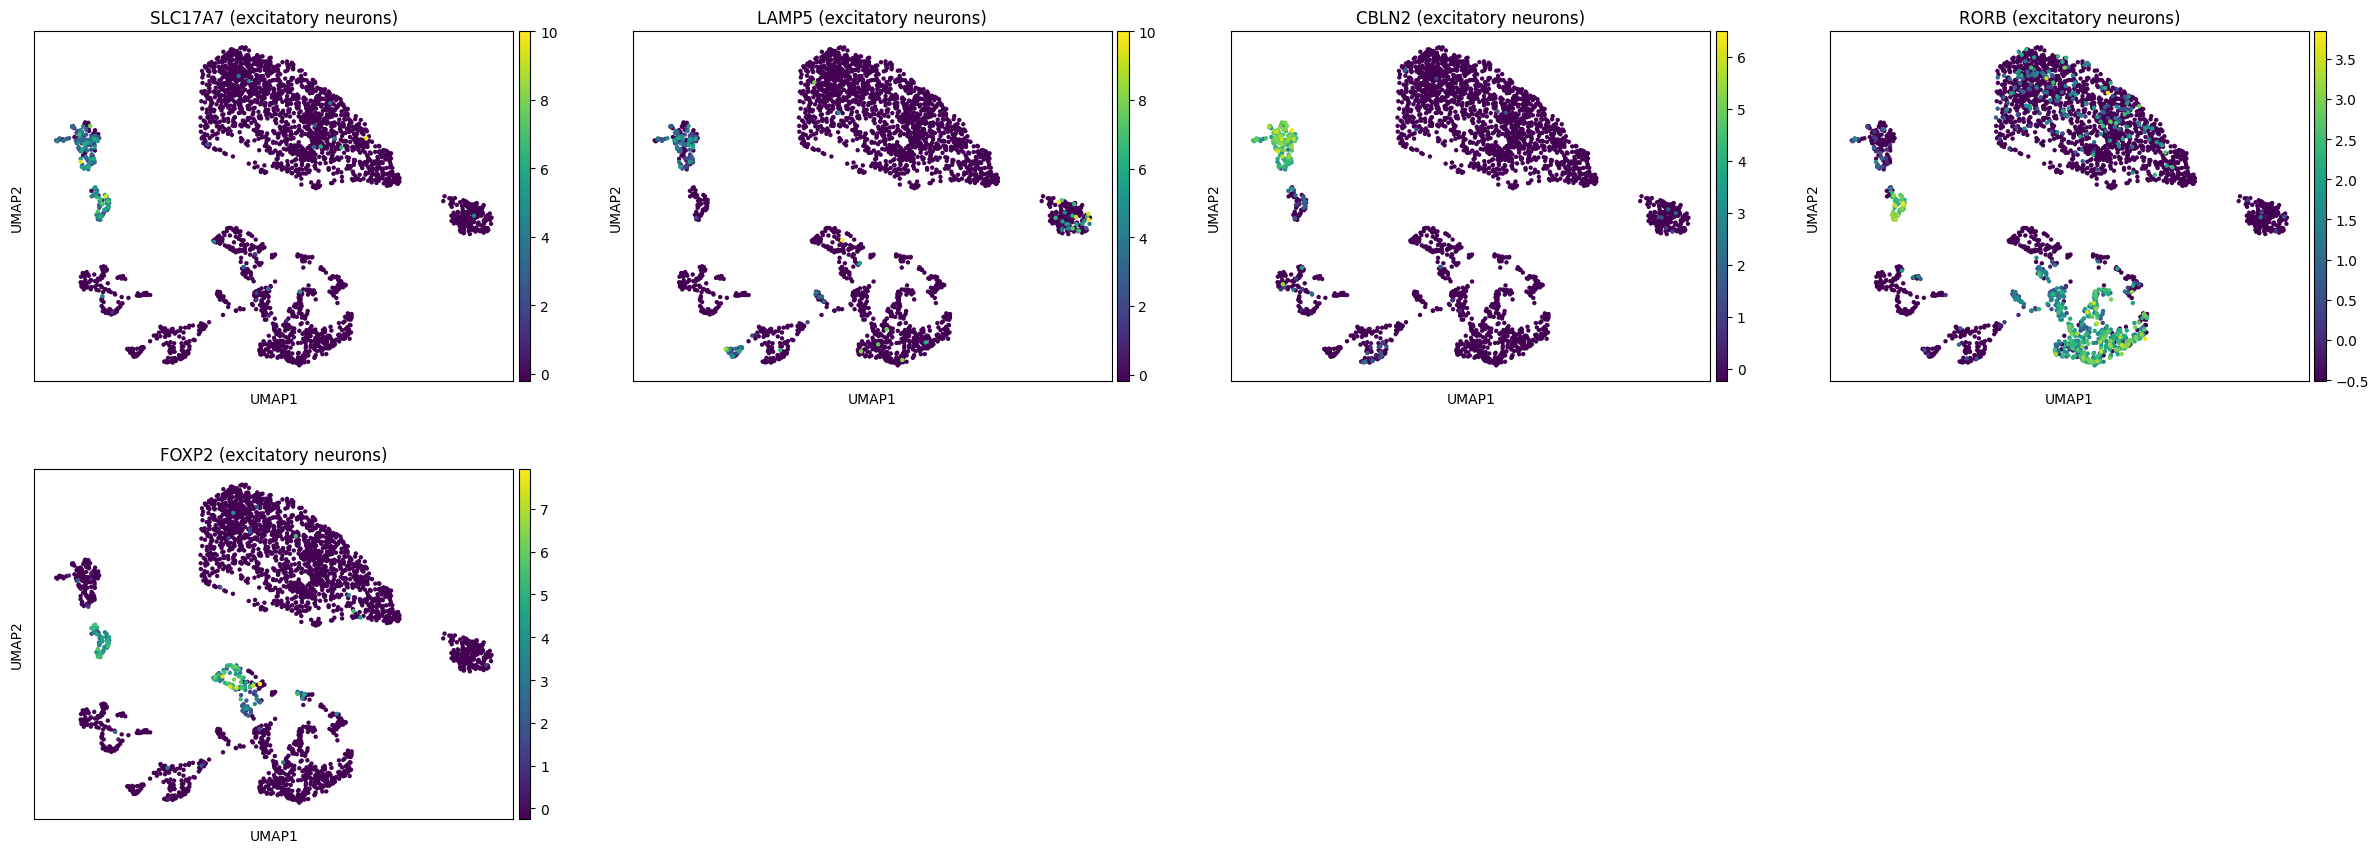

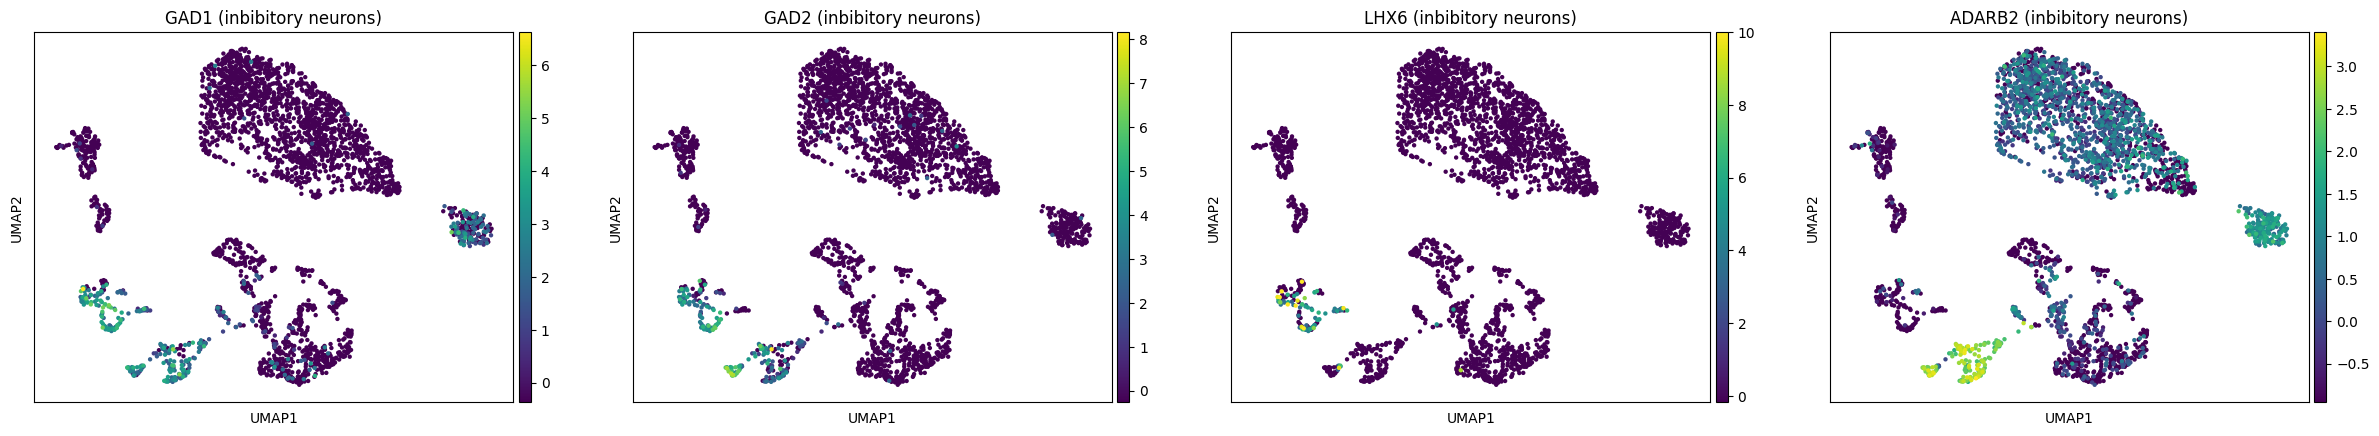

In [55]:
for ct in marker_genes.keys():
    sc.pl.umap(rna_adata, color=marker_genes[ct], title=[f'{x} ({ct})' for x in marker_genes[ct]])

categories: 0, 1, 2, etc.
var_group_labels: oligodendrocytes, astrocytes, microglia, etc.


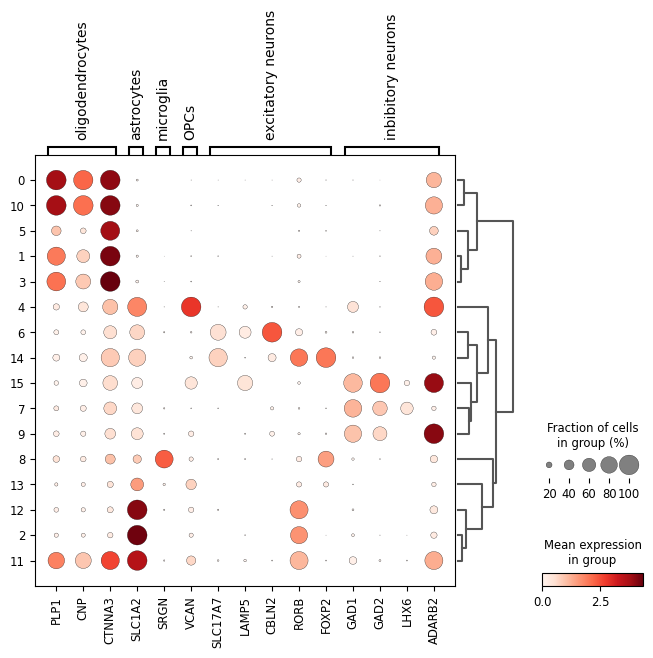

In [65]:
sc.pl.dotplot(rna_adata, marker_genes, groupby='leiden', layer='lognorm', dendrogram=True);

In [99]:
new_cluster_names = {
    '0':'oligodendrocytes',
    '1':'oligodendrocytes',
    '3':'oligodendrocytes',
    '10':'oligodendrocytes',
    '5':'oligodendrocytes',
    '4':'OPCs',
    '6':'excitatory_LAMP5',
    '14':'excitatory_RORB',
    '15':'inhibitory_ADARB2',
    '7':'inhibitory_LHX6',
    '9':'inhibitory_ADARB2',
    '8':'microglia',
    '13':'astrocytes',
    '12':'astrocytes',
    '2':'astrocytes',
    '11':'excitatory_RORB'
}

rna_adata.obs['celltype'] = [new_cluster_names[cl] for cl in rna_adata.obs.leiden.astype("str").values]

/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


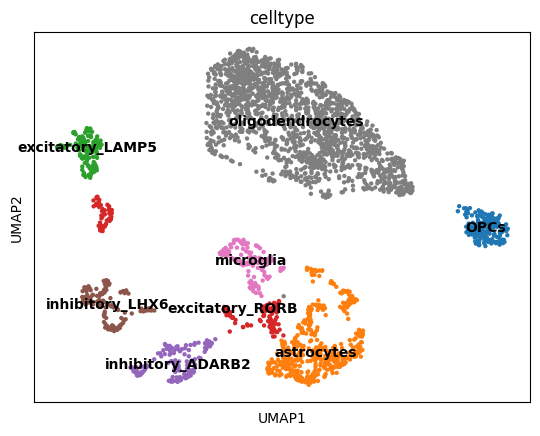

In [100]:
sc.pl.umap(rna_adata, color='celltype', legend_loc='on data')

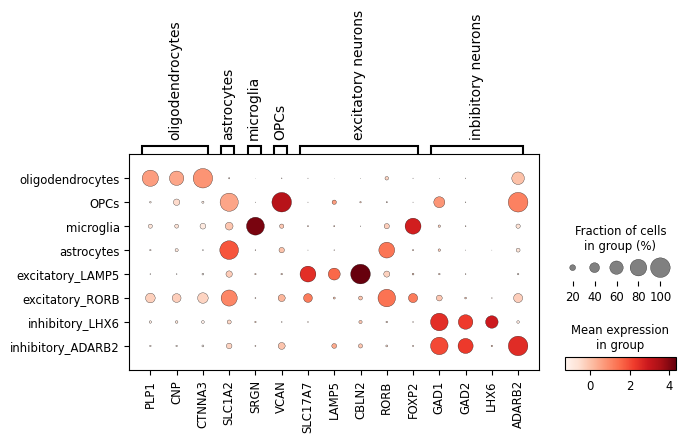

In [101]:
## Reorder categories for plotting
cts_order = [
    'oligodendrocytes', 'OPCs', 'microglia', 'astrocytes',
    'excitatory_LAMP5', 'excitatory_RORB',
    'inhibitory_LHX6', 'inhibitory_ADARB2'
]

sc.pl.dotplot(rna_adata, marker_genes, groupby='celltype', 
              categories_order = cts_order
             );

## Preprocessing ATAC modality

Here most steps resemble scRNA-seq data processing. We use the ATAC processing module in `muon` for certain ATAC specific steps

In [102]:
from muon import atac as ac ## Import muon submodule for ATAC processing

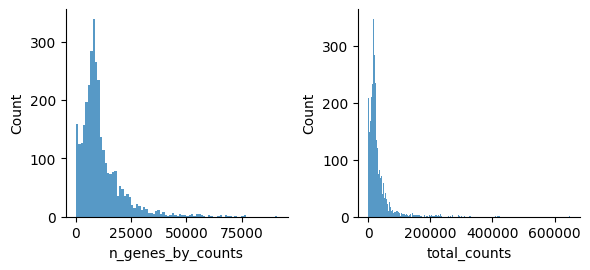

In [103]:
sc.pp.calculate_qc_metrics(atac_adata, percent_top=None, log1p=False, inplace=True)
mu.pl.histogram(atac_adata, ['n_genes_by_counts', 'total_counts'], linewidth=0)

In [104]:
## Filter peaks
mu.pp.filter_var(atac_adata, 'n_cells_by_counts', lambda x: x >= 10)

In [105]:
## Filter cells
print(f"Before: {atac_adata.n_obs} cells")
mu.pp.filter_obs(atac_adata, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
print(f"(After total_counts: {atac_adata.n_obs} cells)")
mu.pp.filter_obs(atac_adata, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))
print(f"After: {atac_adata.n_obs} cells")

Before: 3233 cells
(After total_counts: 2977 cells)
After: 2976 cells


Now we want to perform dimensionality reduction to cluster and visualize our scATAC cells with UMAP. Notably, the stardard PCA on log-normalized counts used for scRNA-seq data isn't ideal for ATAC data, mainly because there is no good way of selecting "highly variable features" in a quasi-binary matrix. Here we will use a simple dimensionality reduction approach called Latent Semantic Indexing (or alternatively Latent Semantic Analysis). Please note that there are several alternative methods/models for dimensionality reduction of scATAC data (e.g. [cisTopic](https://www.nature.com/articles/s41592-019-0367-1), [peakVI](https://www.biorxiv.org/content/10.1101/2021.04.29.442020v1.full), [scOpen](https://www.biorxiv.org/content/10.1101/865931v3)). These are more computationally-intensive, but often show more robust performance than LSI, especially when low quality cells haven't been filtered out thoroughly.

With LSI, we normalize the data to minimize the differences driven by total coverage from each cell using a procedure named Term Frequency - Inverse Document Frequency (or TF-IDF). This is a normalization technique adapted from text processing, where we consider each peak as a "term" in a "document" (the cell). This is typically followed by singular value decomposition (SVD) — the same technique that convential principal component analysis (PCA) uses — to generate latent dimensions. The combination of TF-IDF and SVD is referred to as Latent Semantic Indexing (LSI).

TF-IDF normalization is implemented in `muon.atac`.

In [107]:
## To store raw counts in layers
atac_adata.layers['counts'] = atac_adata.X.copy()

In [108]:
ac.pp.tfidf(atac_adata, scale_factor=1e4)

In [109]:
## For the PCA step, we can use the standard scanpy function or ac.pp.lsi
# (this can take a while, many features!)
sc.pp.pca(atac_adata)

A word of caution on LSI: we often see that the first latent factor or the first few latent factors found with this procedure are very strongly correlated with the total counts in the cells. Some workflows suggest excluding these latent factors that simply capture the coverage. In practice, it's not straight-forward to decide which latent factors should be kept and which should be excluded, so for now we keep them all.

In [110]:
atac_adata.obsm["X_lsi"] = atac_adata.obsm["X_pca"].copy()

/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'feature_types' as categorical
/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecat

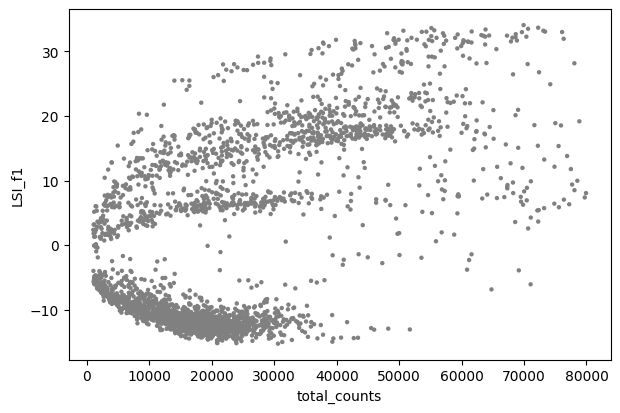

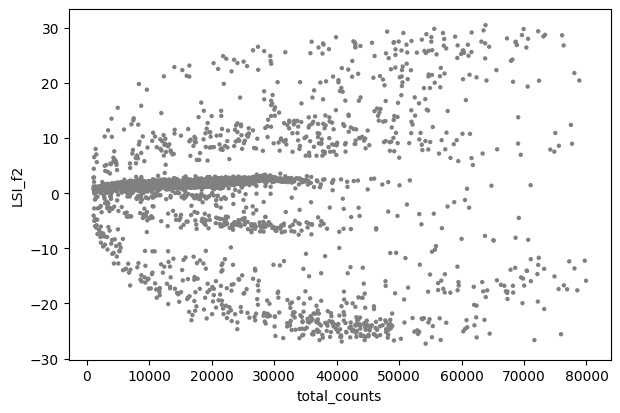

In [111]:
## Store LSI dimensions in .obs for plotting against total counts
atac_adata.obs["LSI_f1"] = atac_adata.obsm["X_lsi"][:,0]
atac_adata.obs["LSI_f2"] = atac_adata.obsm["X_lsi"][:,1]

sc.pl.scatter(atac_adata, "total_counts", "LSI_f1")
sc.pl.scatter(atac_adata, "total_counts", "LSI_f2")

We can now compute a KNN graph for clustering and UMAP

In [112]:
sc.pp.neighbors(atac_adata, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(atac_adata)
sc.tl.leiden(atac_adata, resolution=0.5)

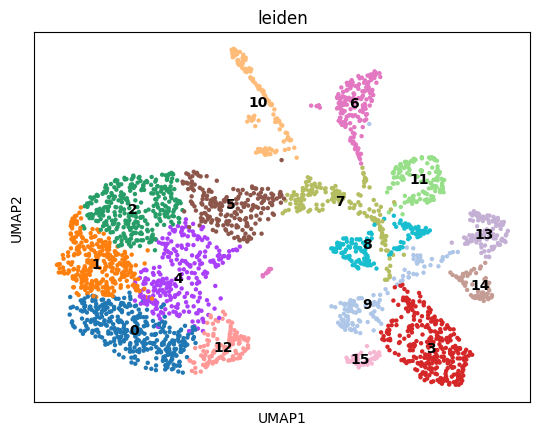

In [113]:
sc.pl.umap(atac_adata, color=["leiden"], legend_loc="on data")

## Joint analysis


We can now build a MuData object to store the information for each modality. `MuData` is a multi-modal data container, that comprises a dictionary with `AnnData` objects, one per modality, in its `.mod` attribute. Just as `AnnData` objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings, etc. See [this tutorial](https://mudata.readthedocs.io/en/latest/index.html) for a more detailed introduction to the `MuData` object structure. 

MuData objects are used in the [`muon`](https://muon.readthedocs.io/en/latest/index.html) library for multi-omics data analysis. 

In [114]:
mdata = mudata.MuData({'rna':rna_adata, 'atac':atac_adata})

In [115]:
mdata

MuData object with n_obs × n_vars = 3167 × 170629
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	3020 x 36601
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'dendrogram_leiden', 'celltype_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'lognorm'
      obsp:	'distances', 'connectivities'
    atac:	2976 x 134028
      obs:	'n_genes_by_counts', 'total_counts', 'LSI_f1', 'LSI_f2', 'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'atac', 'files', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
      obsm:	'X_pca', 'X_lsi', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

In [116]:
mdata.mod

{'rna': AnnData object with n_obs × n_vars = 3020 × 36601
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
     var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'dendrogram_leiden', 'celltype_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts', 'lognorm'
     obsp: 'distances', 'connectivities',
 'atac': AnnData object with n_obs × n_vars = 2976 × 134028
     obs: 'n_genes_by_counts', 'total_counts', 'LSI_f1', 'LSI_f2', 'leiden'
     var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'atac', 'files', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
     obsm: 'X_pca', 'X

You can see the object now concatenates `.obs` from both assays in a single object, and the info about the original assay for each column is saved

In [117]:
mdata.obs

,rna:n_genes_by_counts,rna:total_counts,rna:total_counts_mt,rna:pct_counts_mt,rna:leiden,rna:celltype,atac:n_genes_by_counts,atac:total_counts,atac:LSI_f1,atac:LSI_f2,atac:leiden
AAACAGCCATAGACTT-1,498.0,700.0,0.0,0.000000,5,oligodendrocytes,7862.0,17688.0,-12.314500,1.784313,1
AAACAGCCATTATGCG-1,2862.0,10007.0,17.0,0.169881,1,oligodendrocytes,771.0,1509.0,-5.487365,0.920719,7
AAACCAACATAGACCC-1,2315.0,6017.0,0.0,0.000000,1,oligodendrocytes,8252.0,17955.0,-10.533179,2.556341,4
AAACCGAAGATGCCTG-1,5065.0,15269.0,16.0,0.104787,9,inhibitory_ADARB2,11350.0,25150.0,17.980419,9.072639,8
AAACCGAAGTTAGCTA-1,2608.0,6996.0,9.0,0.128645,0,oligodendrocytes,10821.0,25498.0,-11.147746,1.993215,0
...,...,...,...,...,...,...,...,...,...,...,...
TTGTCAAAGAACCTGT-1,NaN,NaN,NaN,NaN,NaN,NaN,5316.0,12047.0,-13.112350,1.125394,2
TTGTTCCCAATCCTGA-1,NaN,NaN,NaN,NaN,NaN,NaN,16538.0,36247.0,22.954739,12.946771,11
TTTACGCGTGCTCCAC-1,NaN,NaN,NaN,NaN,NaN,NaN,10480.0,24841.0,-10.293662,2.318700,0
TTTCCTGAGGCAATAG-1,NaN,NaN,NaN,NaN,NaN,NaN,4268.0,8819.0,-11.125681,1.538968,2


Observations and variables of the `MuData` object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique.

**Note:** individual modalities inside the MuData container are stored as references to the original objects and are full-fledged AnnData objects, which can be operated independently with any tool that works on AnnData objects (such as the `scanpy` tools). So if we change the single-omic `AnnData` objects, the changes will be reflected in the container.

For example, if we add a column to the `.obs` of the RNA modality object, we can see the new column is also accessible from the container.


In [118]:
rna_adata.obs["new_col"] = 0
mdata["rna"]

AnnData object with n_obs × n_vars = 3020 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype', 'new_col'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'dendrogram_leiden', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'lognorm'
    obsp: 'distances', 'connectivities'

However, the column is not found in the common `.obs`

In [119]:
"rna:new_col" in mdata.obs.columns

False

To update the common obs, we can use the `.update_obs()` method, that syncs up the data.

In [120]:
mdata.update_obs()
mdata.obs["rna:new_col"]

AAACAGCCATAGACTT-1    0.0
AAACAGCCATTATGCG-1    0.0
AAACCAACATAGACCC-1    0.0
AAACCGAAGATGCCTG-1    0.0
AAACCGAAGTTAGCTA-1    0.0
                     ... 
TTGTCAAAGAACCTGT-1    NaN
TTGTTCCCAATCCTGA-1    NaN
TTTACGCGTGCTCCAC-1    NaN
TTTCCTGAGGCAATAG-1    NaN
TTTGGTAAGTTCCTGC-1    NaN
Name: rna:new_col, Length: 3167, dtype: float64

To update everything, not just the `obs`, we can use `mdata.update()`

In [121]:
rna_adata.obs.drop("new_col", axis=1, inplace=True)
mdata.obs.drop("rna:new_col", axis=1, inplace=True)
mdata.update()

In [122]:
mdata.obs

,rna:n_genes_by_counts,rna:total_counts,rna:total_counts_mt,rna:pct_counts_mt,rna:leiden,rna:celltype,atac:n_genes_by_counts,atac:total_counts,atac:LSI_f1,atac:LSI_f2,atac:leiden
AAACAGCCATAGACTT-1,498.0,700.0,0.0,0.000000,5,oligodendrocytes,7862.0,17688.0,-12.314500,1.784313,1
AAACAGCCATTATGCG-1,2862.0,10007.0,17.0,0.169881,1,oligodendrocytes,771.0,1509.0,-5.487365,0.920719,7
AAACCAACATAGACCC-1,2315.0,6017.0,0.0,0.000000,1,oligodendrocytes,8252.0,17955.0,-10.533179,2.556341,4
AAACCGAAGATGCCTG-1,5065.0,15269.0,16.0,0.104787,9,inhibitory_ADARB2,11350.0,25150.0,17.980419,9.072639,8
AAACCGAAGTTAGCTA-1,2608.0,6996.0,9.0,0.128645,0,oligodendrocytes,10821.0,25498.0,-11.147746,1.993215,0
...,...,...,...,...,...,...,...,...,...,...,...
TTGTCAAAGAACCTGT-1,NaN,NaN,NaN,NaN,NaN,NaN,5316.0,12047.0,-13.112350,1.125394,2
TTGTTCCCAATCCTGA-1,NaN,NaN,NaN,NaN,NaN,NaN,16538.0,36247.0,22.954739,12.946771,11
TTTACGCGTGCTCCAC-1,NaN,NaN,NaN,NaN,NaN,NaN,10480.0,24841.0,-10.293662,2.318700,0
TTTCCTGAGGCAATAG-1,NaN,NaN,NaN,NaN,NaN,NaN,4268.0,8819.0,-11.125681,1.538968,2


Let's discard cells that are not in both modalities (if they were filtered independently in two modalities)

In [123]:
mu.pp.intersect_obs(mdata)

We can save the MuData object to a `.h5mu` file

In [124]:
mdata.write(data_dir + "brain3k_processed.h5mu")

/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'feature_types' as categorical
/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecat

We can now start comparing independent clustering of the two modalities

/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/jovyan/my-conda-envs/sys-bio-2022/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'interval' as categorical


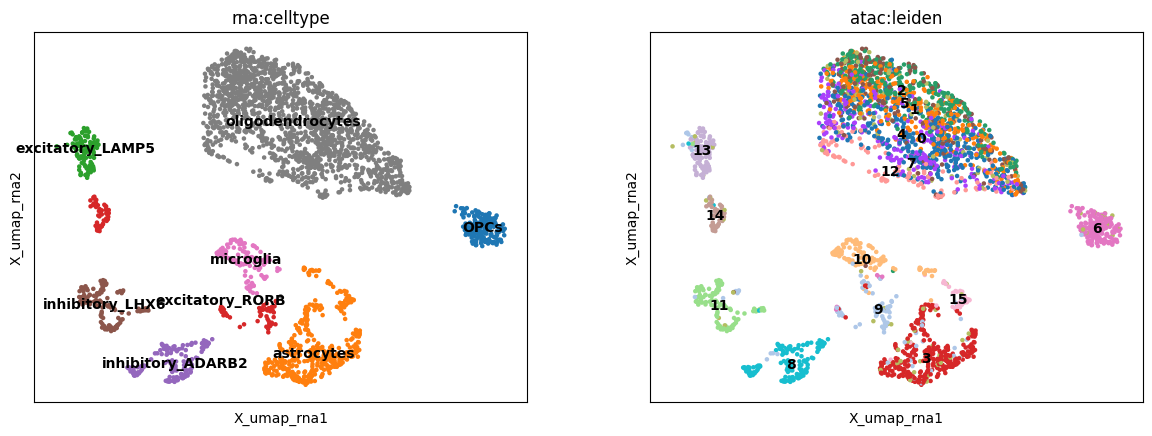

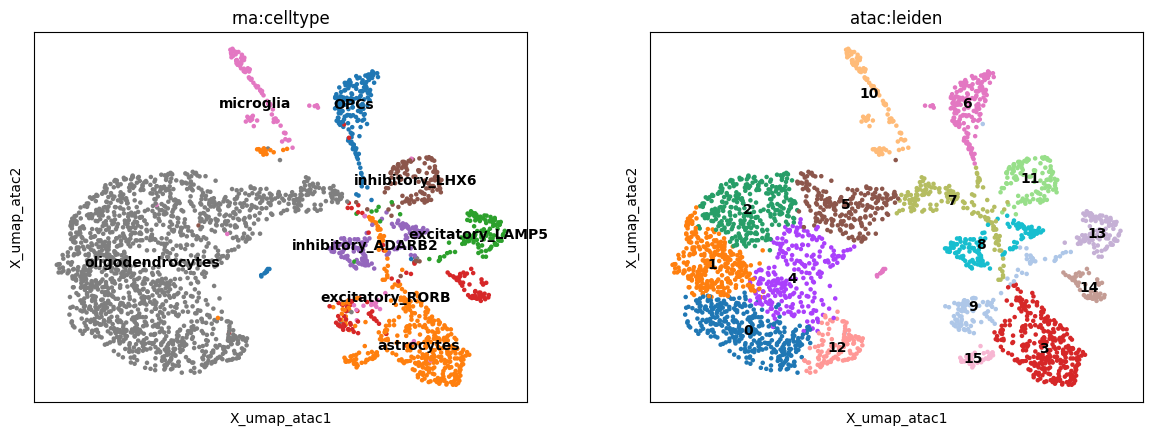

In [125]:
## Save embeddings from individual modalities in mdata.obsm
mdata.obsm['X_umap_rna'] = mdata['rna'].obsm['X_umap'].copy()
mdata.obsm['X_umap_atac'] = mdata['atac'].obsm['X_umap'].copy()

sc.pl.embedding(mdata, basis="X_umap_rna", color=['rna:celltype','atac:leiden'] , legend_loc='on data')
sc.pl.embedding(mdata, basis="X_umap_atac", color=['rna:celltype','atac:leiden'], legend_loc='on data')

### Exercise 1

Use the labels on the gene expression clusters to annotate the clusters in chromatin accessibility. Which RNA clusters are mixed in chromatin accessibility? The utility function `sc.metrics.confusion_matrix` might be useful here.

<details>
<summary>Hint</summary>

```
conf_matrix = sc.metrics.confusion_matrix('rna:celltype','atac:leiden', mdata.obs[['rna:cluster_name','atac:leiden']])
## reorder columns to get a diagonal
row_order = conf_matrix.idxmax(0).sort_values().index 
conf_matrix = conf_matrix[row_order].copy()
sns.heatmap(conf_matrix)
```
    
</details>

### Exercise 2

Does the accessibility at the promoters of marker genes support the cell annotation? You can access the downloaded gene annotation for peaks and add them to `mdata['atac'].var`

In [239]:
peak_anno_df = pd.read_table('./data/brain3k_multiome/atac_peak_annotation.tsv')
## rename rows to match mdata['atac'].var_names
peak_anno_df.index = peak_anno_df.chrom + ':' + peak_anno_df.start.astype('str') + '-' + peak_anno_df.end.astype('str')
peak_anno_df = peak_anno_df[~peak_anno_df.index.duplicated()] ## remove peaks mapped to multiple genes
if any(mdata['atac'].var.columns.isin(['gene', 'distance', 'peak_type'])):
    mdata['atac'].var = mdata['atac'].var.drop(['gene', 'distance', 'peak_type'], 1)
mdata['atac'].var = pd.concat([mdata['atac'].var, peak_anno_df.loc[mdata['atac'].var_names][['gene', 'distance', 'peak_type']]], 1)
mdata.update()

all_markers = sum(marker_genes.values(), [])
mdata['atac'].var[(mdata['atac'].var.gene.isin(all_markers)) & (mdata['atac'].var['peak_type'] == 'promoter')]

/tmp/ipykernel_199/3067656215.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  mdata['atac'].var = mdata['atac'].var.drop(['gene', 'distance', 'peak_type'], 1)
/tmp/ipykernel_199/3067656215.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  mdata['atac'].var = pd.concat([mdata['atac'].var, peak_anno_df.loc[mdata['atac'].var_names][['gene', 'distance', 'peak_type']]], 1)


,gene_ids,feature_types,genome,interval,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,gene,distance,peak_type
chr10:1737098-1737986,chr10:1737098-1737986,Peaks,GRCh38,chr10:1737098-1737986,531,0.424683,83.575626,1373.0,ADARB2,0.0,promoter
chr10:26215934-26216788,chr10:26215934-26216788,Peaks,GRCh38,chr10:26215934-26216788,228,0.179709,92.947727,581.0,GAD2,0.0,promoter
chr10:67695447-67696404,chr10:67695447-67696404,Peaks,GRCh38,chr10:67695447-67696404,82,0.051655,97.463656,167.0,CTNNA3,0.0,promoter
chr10:69087577-69088458,chr10:69087577-69088458,Peaks,GRCh38,chr10:69087577-69088458,125,0.091865,96.133622,297.0,SRGN,0.0,promoter
chr11:35419306-35420052,chr11:35419306-35420052,Peaks,GRCh38,chr11:35419306-35420052,646,0.674915,80.018559,2182.0,SLC1A2,0.0,promoter
chr18:72543144-72543919,chr18:72543144-72543919,Peaks,GRCh38,chr18:72543144-72543919,265,0.181565,91.803279,587.0,CBLN2,0.0,promoter
chr18:72544064-72544846,chr18:72544064-72544846,Peaks,GRCh38,chr18:72544064-72544846,387,0.301887,88.029694,976.0,CBLN2,0.0,promoter
chr18:72638302-72639092,chr18:72638302-72639092,Peaks,GRCh38,chr18:72638302-72639092,100,0.066192,96.906898,214.0,CBLN2,0.0,promoter
chr19:49443278-49444152,chr19:49443278-49444152,Peaks,GRCh38,chr19:49443278-49444152,1097,1.006805,66.068667,3255.0,SLC17A7,-919.0,promoter
chr2:170815441-170816224,chr2:170815441-170816224,Peaks,GRCh38,chr2:170815441-170816224,300,0.213115,90.720693,689.0,GAD1,-338.0,promoter


<details>
<summary>Hint</summary>

```
promoter_peaks = mdata['atac'].var[(mdata['atac'].var.gene.isin(all_markers)) & (mdata['atac'].var['peak_type'] == 'promoter')].index
promoter_gene_names = mdata['atac'].var[(mdata['atac'].var.gene.isin(all_markers)) & (mdata['atac'].var['peak_type'] == 'promoter')].gene.values
gene2ct_dict = {x:k for k,v in marker_genes.items() for x in v}
peak2ct_dict = {promoter_peaks[i]:gene2ct_dict[x] for i,x in enumerate(promoter_gene_names)}
ct2peak_dict = {}
for k,v in peak2ct_dict.items():
    if v not in ct2peak_dict.keys():
        ct2peak_dict[v] = [k]
    else:
        ct2peak_dict[v].append(k)
        
mdata['atac'].obs['rna:celltype'] = mdata.obs['rna:celltype'].copy()
sc.pl.dotplot(mdata['atac'], ct2peak_dict, groupby='rna:celltype')
```
    
<\details>

## Joint dimensionality reduction

Here we will use [weighted nearest-neighbor analysis](https://linkinghub.elsevier.com/retrieve/pii/S0092867421005833), as one example method for dimensionality reduction of multi-modal datasets that incorporate information from both modalities in the embedding, using what we defined as "vertical integration" strategies.

This method uses the KNN graphs for each individual modality, stored in `mdata['rna'].obsp` and `mdata['atac'].obsp`. Therefore changing the dimensions used to calculate KNN graphs in individual modalities will affect the outcome of integration with WNN. 

In [126]:
# Since subsetting was performed after calculating nearest neighbours,
# we have to calculate them again for each modality.
sc.pp.neighbors(mdata['rna'])
sc.pp.neighbors(mdata['atac'])

In [127]:
# Calculate weighted nearest neighbors (should take approx 2.30 minutes)
import time
start_time = time.time()
mu.pp.neighbors(mdata, key_added='wnn')
time.time() - start_time

160.38025569915771

In [128]:
## Compute UMAP embedding from WNN graph
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]

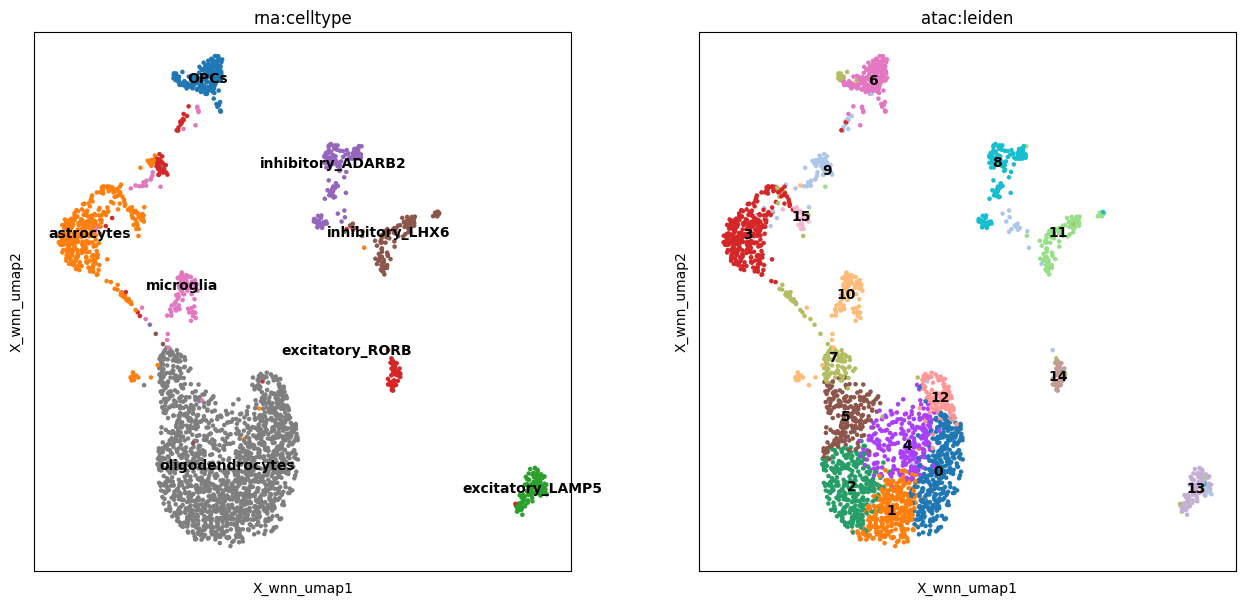

In [129]:
plt.rcParams['figure.figsize'] = [7,7]
mu.pl.embedding(mdata, basis="X_wnn_umap", color=["rna:celltype", "atac:leiden"], legend_loc='on data')

We can access and visualize the modality weights from WNN integration in `mdata.obs`.

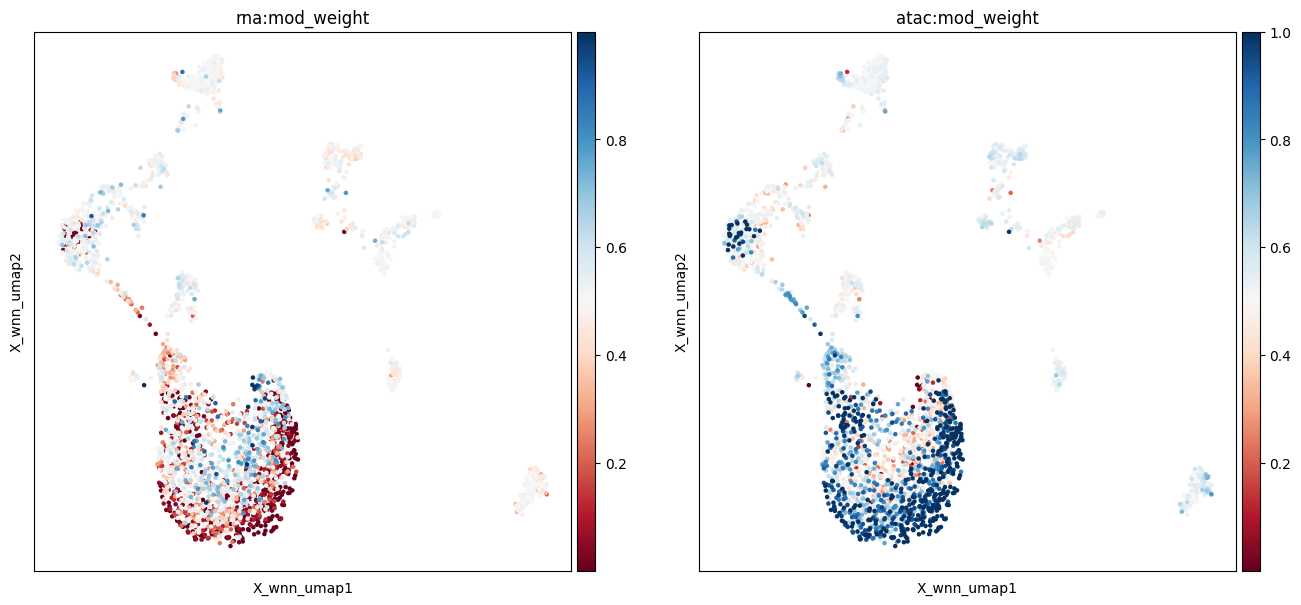

In [130]:
mu.pl.embedding(mdata, basis="X_wnn_umap", color=['rna:mod_weight', 'atac:mod_weight'], legend_loc='on data', cmap='RdBu', vcenter=0.5)

### Exercise 3

Use the WNN integration to repeat clustering and annotate cell types in the multi-modal dataset, using the marker genes from the RNA preprocessing section. Does clustering of the joint space improve cell type definition? You can check again marker genes and promoters.